In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import random
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns
from fancyimpute import KNN, SimpleFill, IterativeImputer

np.set_printoptions(precision=4)
np.set_printoptions(threshold=2000)

# TODO

- Update seeds so this runs consistently every time
- Predictions for various classifiers
- Draw decision boundaries
- issues with p>>n 
    - going to be hard to plot
    - going to be hard to figure out whether to use 'informative' or 'noise' data for these cols
- XOR case vs. decision trees

# Helper Functions

## Create Missing Data

In [14]:
#Creates a copy of a data frame. Each row of each predictor has a [probability] chance of being converted to NaN
def createNaNValues(df, probability = 0.2):
    df = df.copy()
    missingArray = np.random.binomial(size = df.shape[0], n = 1, p = probability)
    #Loop through columns (assumes these are all features)
    for i in range(df.shape[1]):
        df.iloc[np.array(missingArray, dtype=bool),i] = np.nan
    return df
    

## Create Class Imbalance

In [15]:
#Drops observations from the positive class
def dropClassObservations(df,k=1,percentage=0):
    df = df.copy()
    obsToDrop = percentage * df[df["Y"]==1].shape[0]
    drop_indices = np.random.choice(df[df['Y']==1].index, int(obsToDrop), replace=False)
    return df.drop(drop_indices)

## Create Non-Normally Distributed Data

In [16]:
#Sample function to transform class 1 skewed data
def addOne(x):
    return np.add(x,np.ones(x.shape[0]))

#Replace a dataframe column with skewed data. Transforms class 1 observation values with some function
def replaceColumnWithSkewedData(df,column,transformFunc=addOne, degreesFree = 7, scaling = 20):
    df = df.copy()
    #Negative class
    df.loc[df["Y"]==0,column] = np.random.noncentral_chisquare(df=degreesFree, nonc=0, size = df[df["Y"] == 0].shape[0])/scaling
    #Positive class
    df.loc[df["Y"]==1,column] = transformFunc(np.random.noncentral_chisquare(df=degreesFree, nonc=0, size = df[df["Y"] ==1].shape[0])/scaling)
    return df

## Create Collinear Data

In [17]:
def replaceColumnWithCollinearColumn(df,sourceColumn, targetColumn, noiseStd, class1TransformFunc, class0TransformFunc):
    df = df.copy()
    class0Size = df.loc[df["Y"]==0,targetColumn].shape[0]
    class1Size = df.loc[df["Y"]==1,targetColumn].shape[0]
    df.loc[df["Y"]==0,targetColumn] = np.add(class0TransformFunc(df.loc[df["Y"]==0,sourceColumn]),np.random.normal(0,noiseStd,size=class0Size))
    df.loc[df["Y"]==1,targetColumn] = np.add(class1TransformFunc(df.loc[df["Y"]==1,sourceColumn]),np.random.normal(0,noiseStd,size=class1Size))
    return df

## Make Classification

In [18]:
#Create a single dataframe of length n
def generateDataFrame(features=2,informative=2,classImbalance = 0,n_redundant=0,classSeparation=1):
    n=10000
    #If adding class imbalance, generate more data
    if classImbalance > 0:
        n = n + (classImbalance * .5 * n)
        
    X,Y = datasets.make_classification(n_samples = int(n),
                                       n_features=features,
                                       n_redundant=n_redundant ,
                                       n_informative=informative,
                                       n_clusters_per_class=1,
                                       class_sep=classSeparation,
                                       random_state=3)
    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    
    #Merge into 1 dataframe
    Y=Y.rename(index=str,columns={0:"Y"})
    Y.reset_index(drop=True, inplace=True)
    df = pd.concat([X,Y],axis=1)
    
    #Drop observations if we want class imbalance
    if classImbalance > 0:
        df = dropClassObservations(df=df,k=1,percentage=classImbalance)
    
    return df

## Plot Results

In [90]:
def plotResults(test_X,test_Y,train_X, train_Y, title):
    #Generate grid of data points to show prediction
    x = y = np.linspace(-4,4,100)
    df = pd.DataFrame(np.array(np.meshgrid(x,y)).T.reshape(-1,2))
    df = df.rename(index=int, columns={0: "X1", 1: "X2"})

    #Plotting
    fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
    fig.set_size_inches(10, 7)
    plt.suptitle("title", y=1,fontsize=20)
    for i in range(2):
        for j in range(2):
            ax[i][j].set_ylim([-4,4])
            ax[i][j].set_xlim([-4,4])
    

    #Predict with Logistic Regression
    lr = LogisticRegression(random_state=0, solver='lbfgs').fit(train_X, train_Y)
    df["PredictionLR"] = lr.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,lr.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[0][0].set_title("Logistic Regresion\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionLR", data=df, alpha=.6,s=30,ax=ax[0][0])
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[0][0])
    ax[0][0].get_legend().remove()

    #Predict with NB
    nb = GaussianNB().fit(train_X, train_Y)
    df["PredictionNB"] = nb.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,nb.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[0][1].set_title("Naive Bayes\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionNB", data=df, alpha=.6,s=30,ax=ax[0][1])
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[0][1])
    ax[0][1].get_legend().remove()

    #Predict w/ QDA
    qda = QuadraticDiscriminantAnalysis().fit(train_X, train_Y)
    df["PredictionQDA"] = qda.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,qda.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[1][0].set_title("QDA\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionQDA", data=df, alpha=.6,s=30,ax=ax[1][0])
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[1][0])
    ax[1][0].get_legend().remove()

    #Predict w/ Random Forest
    rf = RandomForestClassifier(n_estimators = 100).fit(train_X, train_Y)
    df["PredictionRF"] = rf.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,rf.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[1][1].set_title("Random Forest\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionRF", data=df, alpha=.6,s=30,ax=ax[1][1])
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[1][1])
    ax[1][1].get_legend().remove()

# Generate Data

## Low Degree of Issues

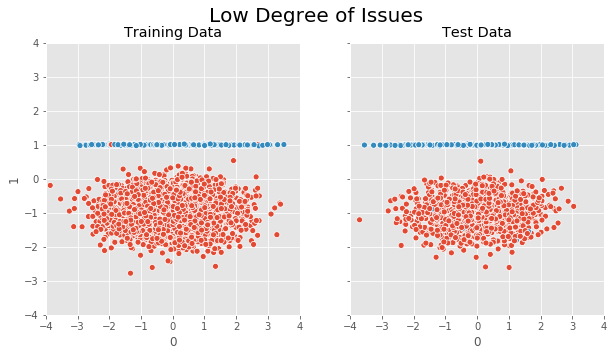

In [86]:
#Create pd dataframe
classImbalance = 0
classSeparation = 1
df_low = generateDataFrame(features=2,informative=1,classImbalance = classImbalance, n_redundant =0, classSeparation = classSeparation)

#Train/test split
X = df_low.iloc[:,0:len(df_low.columns)-1] #grab only the features, assumes label is the last column
Y = df_low["Y"]
X_train_low, X_test_low, Y_train_low, Y_test_low = train_test_split(X, Y, test_size=0.25) #add random_state=1 later

#Plotting
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(10, 5)
plt.suptitle("Low Degree of Issues", fontsize=20)
ax[0].set_ylim([-4,4])
ax[0].set_xlim([-4,4])
ax[1].set_ylim([-4,4])
ax[1].set_xlim([-4,4])

ax[0].set_title("Training Data")

sns.scatterplot(x=X_train_low[0],y=X_train_low[1],hue=Y_train_low, ax=ax[0])
ax[0].get_legend().remove()
ax[1].set_title("Test Data")

sns.scatterplot(x=X_test_low[0],y=X_test_low[1],hue=Y_test_low, ax=ax[1])
ax[1].get_legend().remove()


## Medium Degree of Issues

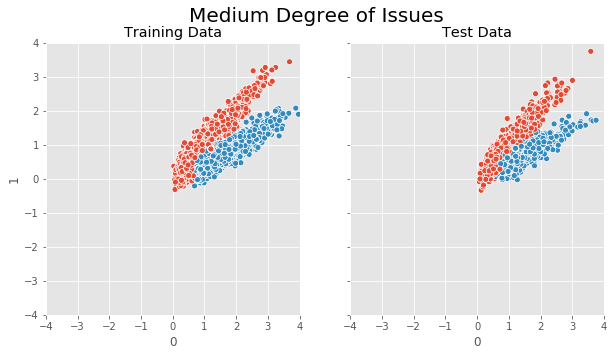

In [95]:
classImbalance = .25
nanPercentage = .25
classSeparation = .5
df_med = generateDataFrame(features=2,informative=1,classImbalance = classImbalance, classSeparation = classSeparation )

#Function to transform the 'skewed' class 1 observations 
def addClassSeparation(x):
    return x+classSeparation
#Replace column 0 with skewed data (chi square distribution)
#Degrees free around 7 looks a little normal, but a little skewed. Dividing by 20 keeps it within 0-3
df_med = replaceColumnWithSkewedData(df_med,0,transformFunc=addClassSeparation, degreesFree = 7, scaling = 7)

#Returns data for destination column based on source column
def class1TransformFunc(source):
    return source*.5
def class0TransformFunc(source):
    return source
df_med = replaceColumnWithCollinearColumn(df_med,sourceColumn=0, targetColumn=1, noiseStd=.2, class1TransformFunc=class1TransformFunc\
                                      , class0TransformFunc=class0TransformFunc)

#Train/test split
X = df_med.iloc[:,0:len(df_med.columns)-1].values #grab only the features, assumes label is the last column
Y = df_med["Y"].values

X_train_med, X_test_med, Y_train_med, Y_test_med = train_test_split(X, Y, test_size=0.25) #add random_state=1 later

#Generate missing values from data (have to run this after train/test split for some reason)
X_train_med = createNaNValues(pd.DataFrame(X_train_med), probability = nanPercentage)
X_test_med = createNaNValues(pd.DataFrame(X_test_med), probability = nanPercentage)

#Impute values using mean. Must run this after train/test split (can't use train data for mean of test data)
X_train_med = pd.DataFrame(SimpleFill().fit_transform(X_train_med))
X_test_med = pd.DataFrame(SimpleFill().fit_transform(X_test_med))

#Plotting
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(10, 5)
plt.suptitle("Medium Degree of Issues", fontsize=20)
ax[0].set_ylim([-4,4])
ax[0].set_xlim([-4,4])
ax[1].set_ylim([-4,4])
ax[1].set_xlim([-4,4])

ax[0].set_title("Training Data")

sns.scatterplot(x=X_train_med[0],y=X_train_med[1],hue=Y_train_med, ax=ax[0])
ax[0].get_legend().remove()
ax[1].set_title("Test Data")

sns.scatterplot(x=X_test_med[0],y=X_test_med[1],hue=Y_test_med, ax=ax[1])
ax[1].get_legend().remove()

## High Degree of Issues

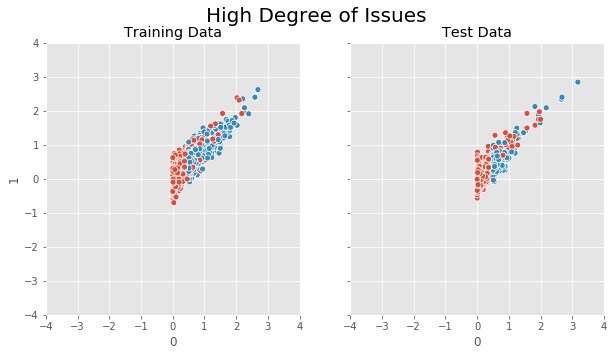

In [96]:
classImbalance = .5
nanPercentage = .5
classSeparation = .5
df_high = generateDataFrame(features=2,informative=1,classImbalance = classImbalance, classSeparation = classSeparation )

#Function to transform the 'skewed' class 1 observations 
def addClassSeparation(x):
    return x+classSeparation
#Replace column 0 with skewed data (chi square distribution)
#Degrees free around 1 is highly skewed
df_high = replaceColumnWithSkewedData(df_high,0,transformFunc=addClassSeparation, degreesFree = 1, scaling = 5)

def class1TransformFunc(source):
    return source*.9
def class0TransformFunc(source):
    return source
df_high = replaceColumnWithCollinearColumn(df_high,sourceColumn=0, targetColumn=1, noiseStd=.2, class1TransformFunc=class1TransformFunc\
                                      , class0TransformFunc=class0TransformFunc)

#Train/test split
X = df_high.iloc[:,0:len(df_high.columns)-1].values #grab only the features, assumes label is the last column
Y = df_high["Y"].values

X_train_high, X_test_high, Y_train_high, Y_test_high = train_test_split(X, Y, test_size=0.25) #add random_state=1 later

#Generate missing values from data (have to run this after train/test split for some reason)
X_train_high = createNaNValues(pd.DataFrame(X_train_high), probability = nanPercentage)
X_test_high = createNaNValues(pd.DataFrame(X_test_high), probability = nanPercentage)

#Impute values using mean. Must run this after train/test split (can't use train data for mean of test data)
X_train_high = pd.DataFrame(SimpleFill().fit_transform(X_train_high))
X_test_high = pd.DataFrame(SimpleFill().fit_transform(X_test_high))

#Plotting
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(10, 5)
plt.suptitle("High Degree of Issues", fontsize=20)
ax[0].set_ylim([-4,4])
ax[0].set_xlim([-4,4])
ax[1].set_ylim([-4,4])
ax[1].set_xlim([-4,4])

ax[0].set_title("Training Data")

sns.scatterplot(x=X_train_high[0],y=X_train_high[1],hue=Y_train_high, ax=ax[0])
ax[0].get_legend().remove()
ax[1].set_title("Test Data")

sns.scatterplot(x=X_test_high[0],y=X_test_high[1],hue=Y_test_high, ax=ax[1])
ax[1].get_legend().remove()


# Prediction

## Low Degree of Issues

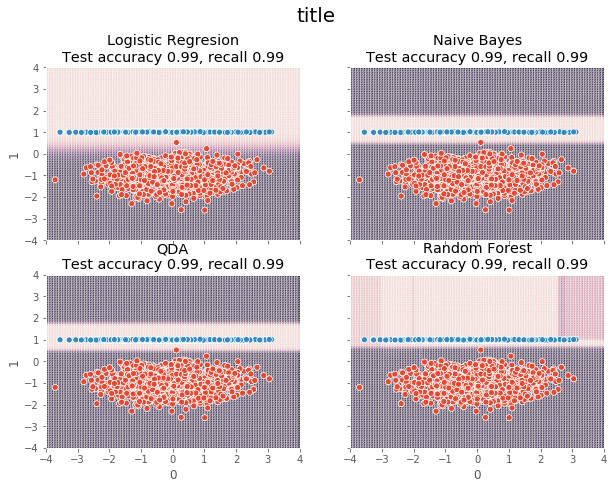

In [91]:
test_X = X_test_low
test_Y = Y_test_low
train_X = X_train_low
train_Y = Y_train_low
title = "Prediction Probabilities with Low Degree of Issues"
plotResults(test_X,test_Y,train_X, train_Y, title)


## Medium Degree of Issues

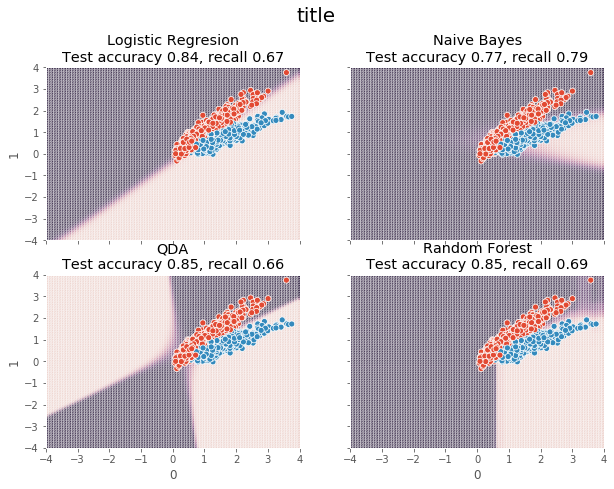

In [97]:
test_X = X_test_med
test_Y = Y_test_med
train_X = X_train_med
train_Y = Y_train_med
title = "Prediction Probabilities with M edium Degree of Issues"
plotResults(test_X,test_Y,train_X, train_Y, title)

## High Degree of Issues

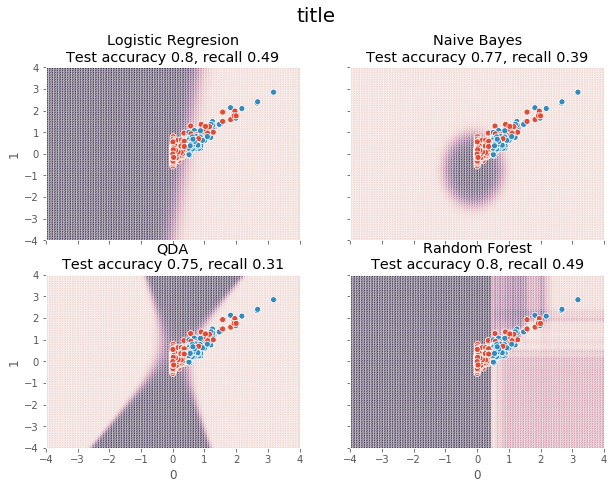

In [98]:
#Setup for low issues
test_X = X_test_high
test_Y = Y_test_high
train_X = X_train_high
train_Y = Y_train_high
title = "Prediction Probabilities with High Degree of Issues"
plotResults(test_X,test_Y,train_X, train_Y, title)